# Read bgen dosages

This notebook offers a tutorial for how to read bgen files in python.

In [64]:
from bgen.reader import BgenFile
import numpy as np
import pandas as pd
import seaborn as sns

In [16]:
bfile = BgenFile("/mnt/speliotes-lab/Projects/MGI/HPI8258/GENODATA/BGEN/MGI_F5_UNFILTERED_chr22_no_phase_8bits.bgen")
rsids = bfile.rsids()
dosages = []
geno_probs = []
for i,variant in enumerate(rsids):
    if i>=10000:
        break
    var = bfile[i]
    dosage = var.alt_dosage
    geno_prob = var.probabilities
    dosages.append(dosage)
    geno_probs.append(geno_prob)
print(len(dosages))

10000


That was a 10000 bgen dosages in 10 seconds. 

Keep in mind that if one were to want to process those dosage variants, the space adds up quickly!

For example MGI is 70,000+ individuals, storing a list of 1000 MGI variants consists of storing 4\*70000\*1000 >= 280_000_000 (>=1 GB)

In [7]:
len(dosages[0])

70266

# Calculating R2 from the dosages and genotype probabilities

In order to calculate the R2 value for a single variant, one would need the haplotype dosages per individual. The haplotype dosages can be back-calculated from the dosages and genotype probabilities. Based on the following equations:
$$d = P(g=1) + 2P(g=2)$$
$$q_1 (1-q_2) + (1-q_1) q_2 = P(g=1)$$
$$q_1 q_2 = P(g=2)$$
where $d$ is the dosage for the given individual, $P(g=1)$ is the probability that the individual's genotype is 1 & $P(g=2)$ is the probability that the individual's genotype is 2, and $q_1$ & $q_2$ are the individual's haplotype probabilities/dosages.

We can rewrite those 3 equations into 2 much simpler equations:
$$d = q_1+q_2$$
$$q_1 q_2 = P(g=2)$$
The intuition behind these equations is fairly obvious. The first is the definition of dosage from haplotype dosages. The second is the law of joint probability.

Solving these systems of equations and completing the square gives us a solution for each haplotype dosage:
$$q_1 = d - q_2$$
$$(d - q_2) q_2 = P(g=2)$$
$$ d q_2 - q_2^2 = P(g=2)$$
$$0 = q^2_2 - d - q_2 + P(g=2)$$
$$q_2 = \frac{d \pm \sqrt{d^2 - 4 P(g=2)}}{2}$$
$$q_1 = \frac{d \pm \sqrt{d^2 - 4 P(g=2)}}{2}$$
$$q_1,q_2 = \frac{d \pm \sqrt{d^2 - 4 P(g=2)}}{2}$$
Two solutions, two variables. Assign one solution to each because order really doesn't matter.

Now the R2 formula is a simple ratio of deviance of the Mean Sum of Squared Differences for individual haplotypes against empirical allele frequency and the standard deviation of the allele frequency assuming haplotypes follow a bernouli random variable.
$$\hat{r}^2 = \frac{\frac{1}{2N} \sum_{i=1}^{2N}(q_i - \hat{q})^2}{\hat{q}(1-\hat{q})}$$

Where *haplotypes* go from $i=1, ..., 2N$. Theoretically we should not observe a variance larger than $\hat{q}(1-\hat{q})$, but I am not certain if this is actually true or why ... please enlighten me if able 🙂

In [66]:
# follow this sequence of formulas for calculating R2
# https://cran.r-project.org/web/packages/BinaryDosage/vignettes/r2estimates.html

def calc_rsq(dosages,geno_prob,i,eps=1e-30):
    n = len(dosages)
    geno_prob2 = geno_prob[:,2]
    q_hat = np.sum(dosages)/(2*n)
    if q_hat > 0.5:
        dosages = 2-dosages
        q_hat = np.sum(dosages)/(2*n)
        geno_prob2 = geno_prob[:,0]
    d_diff = np.square(dosages)-(4*geno_prob2)
    if any(d_diff < 0):
        return np.nan
    q1 = 0.5*(dosages-(d_diff)**0.5)
    q2 = 0.5*(dosages+(d_diff)**0.5)
    num = np.sum((q1-q_hat)**2) + np.sum((q2-q_hat)**2)
    denom = (2*n*q_hat*(1-q_hat))
    if denom == 0:
        denom+=eps
    r2 = num/denom
    return r2

r2s = [calc_rsq(dosages[i],geno_probs[i],i) for i in range(len(dosages))]
print(len(r2s))

10000


10,000 R2 values in 20 seconds, numpy vectoriation is efficient. Make sure to delete the variants `del dosages` and `del geno_probs` since space is the bottleneck with bgen dosages.

# Verification of Results

<Axes: ylabel='Count'>

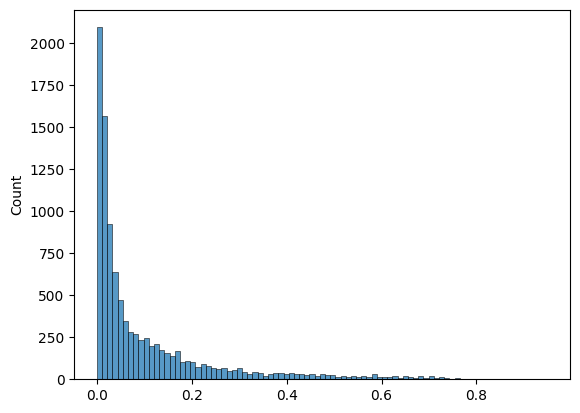

In [65]:
# visualize R2 values in a histogram to make sure that values make sense and follow the intended distribution
sns.histplot(r2s)

In [68]:
r2_map = {rsid:r2 for r2,rsid in zip(r2s,rsids)}
print(len(r2_map))

10000


In [36]:
with open("/mnt/speliotes-lab/Projects/MGI/HPI8258/SAIGE/result/NAFLD_ALL/MGI_HPI8258_TOPMED_NAFLD_ALL_chr22.bgen.new.txt.INFO","r") as f:
    for i,line in enumerate(f):
        print(line.strip())
        if i >10:
            break

MarkerID	imputationInfo
chr22:10510227:A:G	0.152321
chr22:10513650:G:T	0.187015
chr22:10515480:A:G	0.0903411
chr22:10516450:GT:G	0.128852
chr22:10517056:CA:C	0.0997894
chr22:10518420:CA:C	0.107599
chr22:10518603:A:G	0.152328
chr22:10519389:T:C	0.148322
chr22:10527278:T:A	0.25855
chr22:10527415:C:T	0.171471
chr22:10527483:GGC:G	0.110397


In [70]:
saige_infos = pd.read_table("/mnt/speliotes-lab/Projects/MGI/HPI8258/SAIGE/result/NAFLD_ALL/MGI_HPI8258_TOPMED_NAFLD_ALL_chr22.bgen.new.txt.INFO")
print(saige_infos.shape)

(845687, 2)


In [73]:
sus = []
r2_comp_rows = []
for m,r2 in zip(saige_infos.MarkerID, saige_infos.imputationInfo):
    if m in r2_map:
        r2_comp_rows.append({"id":m,"my_r2":r2_map[m],"saige_r2":r2})
        if abs(r2-r2_map[m]) > 0.0001:
            sus.append(m)
r2_comp_df = pd.DataFrame(r2_comp_rows)
print(r2_comp_df.shape)
print(len(sus))
r2_comp_df

(463, 3)
0


,id,my_r2,saige_r2
0,chr22:10510227:A:G,0.152322,0.152321
1,chr22:10513650:G:T,0.187016,0.187015
2,chr22:10515480:A:G,0.090342,0.090341
3,chr22:10516450:GT:G,0.128853,0.128852
4,chr22:10517056:CA:C,0.099790,0.099789
...,...,...,...
458,chr22:11433188:G:A,0.177299,0.177298
459,chr22:11438625:A:G,0.118999,0.118998
460,chr22:11444185:T:C,0.209565,0.209564
461,chr22:11446953:AAAG:A,0.171705,0.171704


So in this brief test of 463 variants, I am able to replicate the R2 value produced by SAIGE within the measurement error margins

In [89]:
%reset -f

ERROR! Session/line number was not unique in database. History logging moved to new session 158


# Scaling up

Recall that memory management is a massive issue. I will demonstrate an example of how to process chr22 dosages in a memory efficient manner, making use of parallelization to speed up the generation of R2 values.

In [1]:
from bgen.reader import BgenFile, BgenReader
import numpy as np
from multiprocessing import Pool

In [2]:
bfile = BgenReader("/mnt/speliotes-lab/Projects/MGI/HPI8258/GENODATA/BGEN/MGI_F5_UNFILTERED_chr22_no_phase_8bits.bgen")
rsids = bfile.rsids()
print(len(rsids))

4140642


In [3]:
rsids[1_000_000]

'chr22:24752376:C:T'

In [20]:
positions = []
bfile = BgenReader("/mnt/speliotes-lab/Projects/MGI/HPI8258/GENODATA/BGEN/MGI_F5_UNFILTERED_chr22_no_phase_8bits.bgen")
for i,var in enumerate(bfile):
    if i %100000 == 0:
        print(f"{i/len(rsids)*100}% done")
    positions.append(var.pos)
print(len(positions))

0.0% done
2.4150844241062135% done
4.830168848212427% done
7.24525327231864% done
9.660337696424854% done
12.075422120531067% done
14.49050654463728% done
16.905590968743496% done
19.320675392849708% done
21.73575981695592% done
24.150844241062135% done
26.565928665168347% done
28.98101308927456% done
31.396097513380777% done
33.81118193748699% done
36.226266361593204% done
38.641350785699416% done
41.05643520980563% done
43.47151963391184% done
45.88660405801805% done
48.30168848212427% done
50.71677290623048% done
53.13185733033669% done
55.54694175444291% done
57.96202617854912% done
60.377110602655335% done
62.792195026761554% done
65.20727945086776% done
67.62236387497398% done
70.0374482990802% done
72.45253272318641% done
74.86761714729262% done
77.28270157139883% done
79.69778599550504% done
82.11287041961126% done
84.52795484371747% done
86.94303926782368% done
89.3581236919299% done
91.7732081160361% done
94.18829254014233% done
96.60337696424854% done
99.01846138835475% done

In [29]:
window_start = min(positions)-1
window_end = max(positions)+1
print(window_start,window_end)
bp_per_job = 100000
rounded_start = window_start//bp_per_job * bp_per_job
rounded_end = (window_end//bp_per_job+1) * (bp_per_job)
print(rounded_start, rounded_end)
# build the batches
batches = [(ws,ws+bp_per_job) for ws in range(rounded_start,rounded_end,bp_per_job)]
print(len(batches))
batches[-5:]

10510226 50807871
10500000 50900000
404


[(50400000, 50500000),
 (50500000, 50600000),
 (50600000, 50700000),
 (50700000, 50800000),
 (50800000, 50900000)]

In [27]:
vars = bfile.fetch(22, start=batches[-1][0], stop=batches[-1][1])

In [28]:
for var in vars:
    dosages = var.alt_dosage

In [40]:
def calc_rsq(dosages,geno_prob,eps=1e-30):
    n = len(dosages)
    geno_prob2 = geno_prob[:,2]
    q_hat = np.sum(dosages)/(2*n)
    if q_hat > 0.5:
        dosages = 2-dosages
        q_hat = np.sum(dosages)/(2*n)
        geno_prob2 = geno_prob[:,0]
    d_diff = np.square(dosages)-(4*geno_prob2)
    d_diff[np.logical_and(d_diff < 0, d_diff > -0.1)] = 0.0
    if any(d_diff < 0):
        # deal with this case later ...
        return np.nan
    d_diff = (d_diff)**0.5
    q1 = 0.5*(dosages-d_diff)
    q2 = 0.5*(dosages+d_diff)
    num = np.sum((q1-q_hat)**2) + np.sum((q2-q_hat)**2)
    denom = (2*n*q_hat*(1-q_hat))
    if denom == 0:
        denom+=eps
    r2 = num/denom
    return r2

def process_batch(batch):
    result = []
    
    with BgenReader("/mnt/speliotes-lab/Projects/MGI/HPI8258/GENODATA/BGEN/MGI_F5_UNFILTERED_chr22_no_phase_8bits.bgen", delay_parsing=True) as bfile:
        vars = bfile.fetch(22, start=batch[0], stop=batch[1])
        for i,var in enumerate(vars):
            rsid = var.rsid
            # if i%10000 == 0:
            #     print(i,rsid)
            dosage = var.alt_dosage
            geno_prob = var.probabilities
            r2 = calc_rsq(dosage,geno_prob)
            result.append({"MarkerID":rsid,"R2":r2})
    return result

batch_0 = process_batch(batches[-20])
batch_1 = process_batch(batches[-10])
print(len(batch_0),len(batch_1))

16221 14419


In [35]:
batch_0[:10]

[{'MarkerID': 'chr22:48900003:C:T', 'R2': 0.7229040725922776},
 {'MarkerID': 'chr22:48900004:A:G', 'R2': 0.9321788377637905},
 {'MarkerID': 'chr22:48900008:C:T', 'R2': 0.8001940833555139},
 {'MarkerID': 'chr22:48900011:G:A', 'R2': 0.6245013362018397},
 {'MarkerID': 'chr22:48900023:T:G', 'R2': 0.30536758766504274},
 {'MarkerID': 'chr22:48900035:C:A', 'R2': 0.928720287234621},
 {'MarkerID': 'chr22:48900035:C:T', 'R2': 0.29665077651077404},
 {'MarkerID': 'chr22:48900037:C:T', 'R2': 0.4924804485762132},
 {'MarkerID': 'chr22:48900038:G:A', 'R2': 0.5838764000394133},
 {'MarkerID': 'chr22:48900038:G:C', 'R2': 0.020963101229438025}]

In [36]:
batch_1[:10]

[{'MarkerID': 'chr22:49900003:A:T', 'R2': 0.502935630343228},
 {'MarkerID': 'chr22:49900004:T:A', 'R2': 0.4855231777511671},
 {'MarkerID': 'chr22:49900009:T:A', 'R2': 0.7983518586209629},
 {'MarkerID': 'chr22:49900018:G:C', 'R2': 0.19109896117621397},
 {'MarkerID': 'chr22:49900038:C:A', 'R2': 0.006162175485783074},
 {'MarkerID': 'chr22:49900045:T:A', 'R2': 0.8571859674549261},
 {'MarkerID': 'chr22:49900054:C:T', 'R2': 0.28806926406439143},
 {'MarkerID': 'chr22:49900074:G:A', 'R2': 0.9741784708730795},
 {'MarkerID': 'chr22:49900075:G:A', 'R2': 0.10494748307867147},
 {'MarkerID': 'chr22:49900081:T:G', 'R2': 0.41812637256614404}]

In [37]:
print(len(batches))

404


In [41]:
mini_batches = batches[32*5:32*6]

with Pool(32) as pool:
    results = pool.map(process_batch,mini_batches)
    print(len(results))

32


In [42]:
collapsed_result = [res for batch in results for res in batch]
print(len(collapsed_result))

358014


(358014, 2)


<Axes: xlabel='R2', ylabel='Count'>

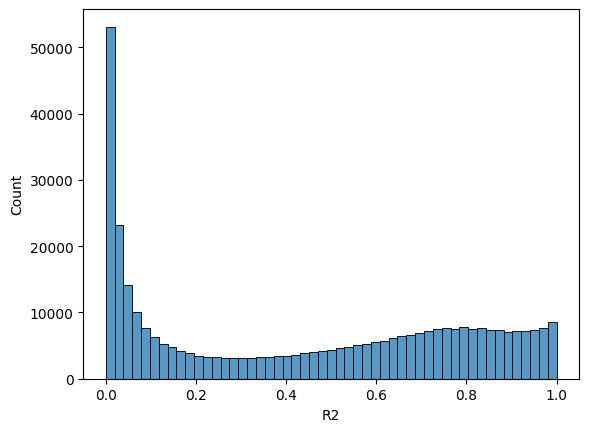

In [43]:
import pandas as pd
import seaborn as sns
collapsed_df = pd.DataFrame(collapsed_result)
print(collapsed_df.shape)
sns.histplot(collapsed_df.R2)

That was 350,000 variants in 30 seconds. At that rate it should take chromosome 22 about 6 minutes to finish

In [44]:
with Pool(32) as pool:
    results = pool.map(process_batch,batches)
    print(len(results))
collapsed_result = [res for batch in results for res in batch]
print(len(collapsed_result))

404
4140683


In [45]:
# note due to the base pair position grabbing. I think it is possible for duplicates since they are double-end inclusive
recorded_var = set()
filtered_result = []
for row in collapsed_result:
    if row["MarkerID"] not in recorded_var:
        filtered_result.append(row)
        recorded_var.add(row["MarkerID"])
print(len(filtered_result),len(rsids))

4140642 4140642
